In [10]:
# 首先加载必用的库
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('./Chinese-Word-Vectors/sgns.zhihu.bigram', 
                                          binary=False)

In [16]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['中国科学院大学'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
cn_model['中国科学院大学']

词向量的长度为300


array([-1.52890e-02,  2.31024e-01, -2.80849e-01,  9.61630e-02,
       -2.34274e-01, -2.56216e-01, -1.74254e-01,  4.28950e-02,
       -9.34530e-02, -6.80950e-02, -3.45513e-01,  4.01743e-01,
        1.85933e-01, -6.76800e-03,  2.78017e-01, -2.73296e-01,
        1.24047e-01,  4.47420e-02,  2.92976e-01,  1.61150e-01,
        2.05206e-01,  2.31574e-01, -1.36014e-01, -9.25440e-02,
       -2.01687e-01, -6.82280e-02, -1.86219e-01,  4.97290e-02,
        4.63300e-02,  2.84313e-01, -9.85180e-02, -8.82120e-02,
       -4.12759e-01,  1.68289e-01,  1.09890e-02,  7.07480e-02,
       -4.78080e-02,  1.34126e-01, -6.52060e-02,  6.63480e-02,
       -1.83489e-01, -1.33973e-01, -1.60334e-01,  4.64950e-02,
        2.01834e-01,  1.40247e-01,  5.37790e-02,  7.44170e-02,
        4.08340e-02,  2.93954e-01,  1.10000e-04, -2.27480e-01,
       -1.41560e-02, -7.80640e-02, -8.98120e-02, -8.10800e-03,
       -1.71551e-01,  2.44673e-01, -3.87660e-02,  5.12030e-02,
        6.72050e-02,  4.45319e-01, -1.18807e-01,  6.630

In [18]:
# 计算相似度
cn_model.similarity('橘子', '香蕉')

0.5495229561979689

In [21]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['草地'], topn=10)

[('灌丛', 0.663927435874939),
 ('沙地', 0.6615739464759827),
 ('草甸', 0.6611600518226624),
 ('泥地', 0.6470364928245544),
 ('草地上', 0.6465343236923218),
 ('香樟', 0.6445313692092896),
 ('绿树', 0.6404516696929932),
 ('山坡上', 0.638901948928833),
 ('草皮', 0.6353737115859985),
 ('绿茵', 0.634978711605072)]

In [22]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 老人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 老师 会计师 程序员 律师 医生 老人 中:
不是同一类别的词为: 老人


In [23]:
cn_model.most_similar(positive=['女人','出轨'], negative=['男人'], topn=1)


[('劈腿', 0.5849199295043945)]

In [25]:
# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# 每个文件夹中有2000个txt文件，每个文件中是一例评价
import os
pos_txts = os.listdir('./Chinese-Word-Vectors/pos')
neg_txts = os.listdir('./Chinese-Word-Vectors/neg')

In [26]:
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)) )


样本总共: 4000


In [28]:
# 现在我们将所有的评价内容放置到一个list里

train_texts_orig = [] # 存储所有评价，每例评价为一条string

# 添加完所有样本之后，train_texts_orig为一个含有4000条文本的list
# 其中前2000条文本为正面评价，后2000条为负面评价

for i in range(len(pos_txts)):
    with open('./Chinese-Word-Vectors/pos/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('./Chinese-Word-Vectors/neg/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [31]:
len(train_texts_orig)

4000

In [32]:
# 我们使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [33]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.933 seconds.
Prefix dict has been built succesfully.


In [34]:

# 获得所有tokens的长度# 获得所有to 
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [35]:
# 平均tokens的长度
np.mean(num_tokens)

48.2

In [36]:
# 最长的评价tokens的长度
np.max(num_tokens)

1054

ValueError: supplied range of [-inf, 6.960347729101308] is not finite

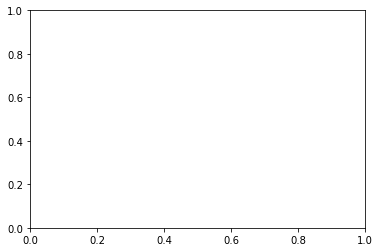

In [102]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [40]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

157

In [41]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.95475

In [99]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [100]:
reverse = reverse_tokens(train_tokens[1])


In [101]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

' ̫         ο  л      ı  廬о ´         ι   '

In [48]:
embedding_dim

300

In [49]:
# 只使用前20000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [50]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [51]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

In [52]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [53]:

# 超出五万个词向量的词用0代替# 超出五万个词 
train_pad[ train_pad>=num_words ] = 0

In [54]:

# 可见padding之后前面的tokens全变成0，文本在最后面# 可见padd 
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   443, 16952,     0,     0,
           0,     0,

In [55]:

# 准备target向量，前2000样本为1，后2000为0# 准备targ 
train_target = np.concatenate( (np.ones(2000),np.zeros(2000)) )

In [56]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [57]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [58]:

# 查看训练样本，确认无误# 查看训练样本 
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

                                                                                                                                             ú    10          
class:  1.0


In [59]:
# 用LSTM对样本进行分类
model = Sequential()

In [63]:
# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

In [78]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

ValueError: Input 0 of layer bidirectional_3 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 157, 300, 1]

In [79]:
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

In [81]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [82]:
# 我们来看一下模型的结构，一共90k左右可训练的变量
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 157, 300)          15000000  
_________________________________________________________________
embedding_1 (Embedding)      (None, 157, 300, 300)     15000000  
_________________________________________________________________
dense (Dense)                (None, 157, 300, 1)       301       
_________________________________________________________________
dense_1 (Dense)              (None, 157, 300, 1)       2         
Total params: 30,000,303
Trainable params: 303
Non-trainable params: 30,000,000
_________________________________________________________________


In [83]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [84]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

`load_weights` requires h5py when loading weights from HDF5.


In [85]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [86]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [87]:
# 定义callback函数# 定义call 
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [88]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

ValueError: Error when checking target: expected dense_1 to have 4 dimensions, but got array with shape (3600, 1)

In [90]:

resultresult  =  model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

ValueError: Error when checking target: expected dense_1 to have 4 dimensions, but got array with shape (400, 1)

In [91]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [92]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [93]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [94]:

y_actualy_actual = np.array(y_test)

In [95]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

NameError: name 'y_actual' is not defined

In [96]:

# 输出所有错误分类的索引# 输出所有错误 
len(misclassified)
print(len(X_test))

NameError: name 'misclassified' is not defined

In [97]:
# 我们来找出错误分类的样本看看
idx=101
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                              з              
预测的分类 [[0.5090369  0.5090369  0.5090369  ... 0.5090369  0.5090369  0.5090369 ]
 [0.5090369  0.5090369  0.5090369  ... 0.5090369  0.5090369  0.5090369 ]
 [0.5090369  0.5090369  0.5090369  ... 0.5090369  0.5090369  0.5090369 ]
 ...
 [0.5090369  0.5090369  0.5090369  ... 0.5090369  0.5090369  0.5090369 ]
 [0.5090369  0.5090369  0.5090369  ... 0.5090369  0.5090369  0.52263117]
 [0.5090369  0.5090369  0.5090369  ... 0.5090369  0.5090369  0.5090369 ]]


NameError: name 'y_actual' is not defined

In [98]:
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                                             
预测的分类 [[0.5090369 0.5090369 0.5090369 ... 0.5090369 0.5090369 0.5090369]
 [0.5090369 0.5090369 0.5090369 ... 0.5090369 0.5090369 0.5090369]
 [0.5090369 0.5090369 0.5090369 ... 0.5090369 0.5090369 0.5090369]
 ...
 [0.5090369 0.5090369 0.5090369 ... 0.5090369 0.5090369 0.5090369]
 [0.5090369 0.5090369 0.5090369 ... 0.5090369 0.5090369 0.5090369]
 [0.5090369 0.5090369 0.5090369 ... 0.5090369 0.5090369 0.5090369]]


NameError: name 'y_actual' is not defined